In [2]:
import os
from timeit import default_timer as timer
import pandas as pd
from datetime import datetime, timedelta
from glob import glob
from pathlib import Path
import pandas as pd
import numpy as np
import geopandas as gpd

In [3]:
path_to_data='/scratch/spf248/covid/data'
start_date='01/01/2020'
end_date='04/16/2020'
source='cuebiq'
country='ID'
admin_id='ADM4_PCODE'
city_id='UC_NM_MN'
demographics=[
'wealth_index',
'population_density',
]
day=list(range(8,20))
night=list(range(8))+list(range(20,24))
q_days=0.5
min_pings=20

# Compute share of activity in unique neighborhoods

In [3]:
def get_coords(df):
    df['latitude']=df['point'].apply(lambda x:x['latitude'])
    df['longitude']=df['point'].apply(lambda x:x['longitude'])
    return df.drop('point',1)

In [4]:
print('Import')
start = timer()
data_dirs=glob(os.path.join(path_to_data,source,'processed',country,'pings_geocoded','*'))
pings_geocoded = pd.concat(
    pd.read_parquet(parquet_file)
    for data_dir in data_dirs for parquet_file in Path(data_dir).glob('*.parquet')
)
print("Done in", round(timer()-start), "sec")  

Import
Done in 134 sec


In [5]:
print('Process')
start = timer()
pings_geocoded['date']=pd.to_datetime(pings_geocoded.time.dt.date)
pings_geocoded['hour']=pings_geocoded.time.dt.hour
print("Done in", round(timer()-start), "sec")  

Process
Done in 147 sec


In [6]:
print('Count neighborhood visits')
start = timer()
n_admin_date_id=pings_geocoded.groupby(['date','cuebiq_id'])[admin_id].agg(['nunique','count'])
n_admin_daytime_id=pings_geocoded[pings_geocoded.hour.isin(day)].groupby(['date','cuebiq_id'])[admin_id].agg(['nunique','count'])
n_admin_nighttime_id=pings_geocoded[pings_geocoded.hour.isin(night)].groupby(['date','cuebiq_id'])[admin_id].agg(['nunique','count'])
print("Done in", round(timer()-start), "sec")

Count neighborhood visits
Done in 1184 sec


In [80]:
print('Process')
start = timer()
n_admin_date_id['pct_unique']=n_admin_date_id['nunique'].divide(n_admin_date_id['count'])
n_admin_daytime_id['pct_unique']=n_admin_daytime_id['nunique'].divide(n_admin_daytime_id['count'])
n_admin_nighttime_id['pct_unique']=n_admin_nighttime_id['nunique'].divide(n_admin_nighttime_id['count'])
n_admin_date_id=n_admin_date_id[n_admin_date_id.index.get_level_values('date').isin(pd.date_range(start_date,end_date))].copy()
n_admin_daytime_id=n_admin_daytime_id[n_admin_daytime_id.index.get_level_values('date').isin(pd.date_range(start_date,end_date))].copy()
n_admin_nighttime_id=n_admin_nighttime_id[n_admin_nighttime_id.index.get_level_values('date').isin(pd.date_range(start_date,end_date))].copy()
n_admin_date_id.rename(columns={'count':'n_pings'},inplace=True)
n_admin_daytime_id.rename(columns={'count':'n_pings'},inplace=True)
n_admin_nighttime_id.rename(columns={'count':'n_pings'},inplace=True)
print("Done in", round(timer()-start), "sec")

In [8]:
print('Save')
start = timer()
n_admin_date_id.to_csv(os.path.join(path_to_data,source,'processed',country,'n_admin_date_id.csv'))
n_admin_daytime_id.to_csv(os.path.join(path_to_data,source,'processed',country,'n_admin_daytime_id.csv'))
n_admin_nighttime_id.to_csv(os.path.join(path_to_data,source,'processed',country,'n_admin_nighttime_id.csv'))
print("Done in", round(timer()-start), "sec")

Save
Done in 66 sec


# Figures

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

/share/apps/anaconda3/2019.10/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
print('Load results')
start = timer()
n_admin_date_id=pd.read_csv(os.path.join(path_to_data,source,'processed',country,'n_admin_date_id.csv'))
n_admin_daytime_id=pd.read_csv(os.path.join(path_to_data,source,'processed',country,'n_admin_daytime_id.csv'))
n_admin_nighttime_id=pd.read_csv(os.path.join(path_to_data,source,'processed',country,'n_admin_nighttime_id.csv'))
print("Done in", round(timer()-start), "sec")

Load results
Done in 16 sec


In [13]:
print('Days of Activity')
start = timer()
ndays=n_admin_date_id.groupby('cuebiq_id')['date'].nunique()
print("Done in", round(timer()-start), "sec")

Days of Activity
Done in 7 sec


Figure


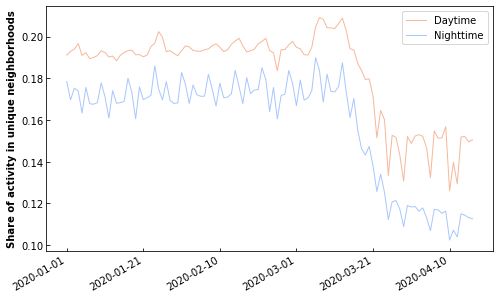

In [16]:
print('Figure')
fig,ax=plt.subplots(figsize=(8,5))
for i,(data,label) in enumerate(zip([n_admin_daytime_id,n_admin_nighttime_id],['Daytime','Nighttime'])):
    data[(data['count']>=min_pings)&(data['cuebiq_id'].isin(
    ndays[ndays>=ndays.quantile(q_days)].index))].groupby('date')['pct_unique'].mean().plot(
    ax=ax,linewidth=1,color=sns.color_palette("coolwarm", 2)[1-i],label=label)
ax.tick_params(which='both',direction='in',pad=3)
ax.locator_params(axis='y',nbins=7)
ax.set_xlabel('')
ax.set_ylabel('Share of activity in unique neighborhoods',fontweight='bold')
ax.legend(loc='best')
fig.autofmt_xdate()
plt.savefig(os.path.join(path_to_data+'/../fig',country,'share-of-activity-in-unique-neighborhoods.pdf'),bbox_inches='tight')

# Demographics

In [102]:
print('Import')
start = timer()
data_dir = Path(os.path.join(path_to_data,source,'processed',country,'primary_home'))
primary_home = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in data_dir.glob('*.parquet')
)
print("Done in", round(timer()-start), "sec")  

Import
Done in 2 sec


In [10]:
print('Import')
start = timer()
admin=gpd.read_file(os.path.join(path_to_data,'admin',country,'admin.geojson'))
admin2city=pd.read_excel(os.path.join(path_to_data,'admin',country,'city2adminGHSL.xlsx'))[[city_id,admin_id]].drop_duplicates(admin_id)
print("Done in", round(timer()-start), "sec")  

Import
Done in 65 sec


In [11]:
print('Merge admin and home data')
start = timer()
primary_home=get_coords(primary_home)
primary_home=gpd.GeoDataFrame(primary_home,geometry=gpd.points_from_xy(primary_home.longitude,primary_home.latitude))
primary_home.crs='epsg:4326'
geocoded_home=gpd.sjoin(primary_home[['cuebiq_id','geometry']],admin,op='intersects')
geocoded_home=geocoded_home.merge(admin2city,on=admin_id,how='left')
geocoded_home['population_density']=geocoded_home['total_population'].divide(geocoded_home['a_km2'])
for col in demographics:
    print(col)
    geocoded_home[col+'_quantile']=pd.qcut(geocoded_home[col],2,range(1,3))
print("Done in", round(timer()-start), "sec")  

Merge admin and home data
wealth_index
population_density
Done in 21 sec


# Neighborhood Visits by Demographic Groups

In [103]:
n_admin_date_id_demog=n_admin_date_id.reset_index().merge(geocoded_home,on='cuebiq_id')
n_admin_date_id_demog['pct_unique']=n_admin_date_id_demog['nunique'].divide(n_admin_date_id_demog['count'])

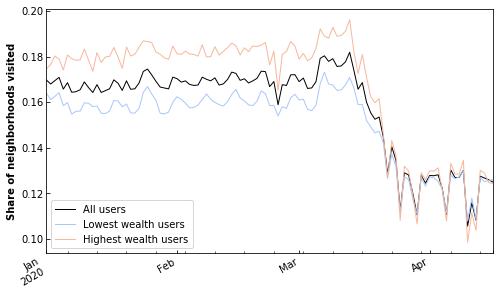

In [106]:
fig,ax=plt.subplots(figsize=(8,5))

n_admin_date_id[(n_admin_date_id['count']>=min_pings)&\
(n_admin_date_id.index.get_level_values('cuebiq_id').isin(
ndays[ndays>=ndays.quantile(q_days)].index))].groupby('date')['pct_unique'].mean().plot(
ax=ax,linewidth=1,color='k',label='All users')

for i,(val,name) in enumerate(zip([1,2],['Lowest wealth users','Highest wealth users'])):
    
    n_admin_date_id_demog[(n_admin_date_id_demog['count']>=min_pings)&\
    (n_admin_date_id_demog['cuebiq_id'].isin(
    ndays[ndays>=ndays.quantile(q_days)].index))].groupby(
    ['wealth_index_quantile','date'])['pct_unique'].mean().loc[val].plot(
    ax=ax,linewidth=1,color=sns.color_palette("coolwarm", 2)[i],label=name)

ax.tick_params(which='both',direction='in',pad=3)
ax.locator_params(axis='y',nbins=6)
ax.set_xlabel('')
ax.set_ylabel('Share of neighborhoods visited',fontweight='bold')
ax.legend(loc='best')
fig.autofmt_xdate()

plt.savefig(os.path.join(path_to_data+'/../fig',country,'share-of-neighborhoods-visited-by-wealth.pdf'),bbox_inches='tight')

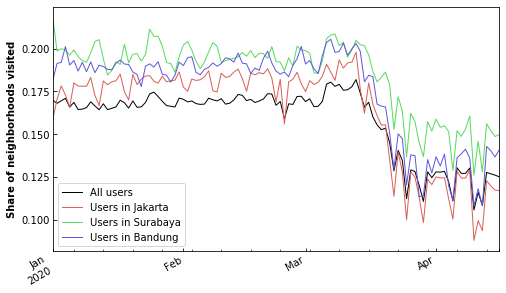

In [107]:
fig,ax=plt.subplots(figsize=(8,5))

n_admin_date_id[(n_admin_date_id['count']>=min_pings)&\
(n_admin_date_id.index.get_level_values('cuebiq_id').isin(
ndays[ndays>=ndays.quantile(q_days)].index))].groupby('date')['pct_unique'].mean().plot(
ax=ax,linewidth=1,color='k',label='All users')

top_cities=geocoded_home.UC_NM_MN.value_counts().index[:3]
for i,name in enumerate(top_cities):
    
    n_admin_date_id_demog[(n_admin_date_id_demog['count']>=min_pings)&\
    (n_admin_date_id_demog['cuebiq_id'].isin(
    ndays[ndays>=ndays.quantile(q_days)].index))].groupby(
    [city_id,'date'])['pct_unique'].mean().loc[name].plot(
    ax=ax,linewidth=1,color=sns.color_palette("hls", len(top_cities))[i],label='Users in '+name)

ax.tick_params(which='both',direction='in',pad=3)
ax.locator_params(axis='y',nbins=6)
ax.set_xlabel('')
ax.set_ylabel('Share of neighborhoods visited',fontweight='bold')
ax.legend(loc='best')
fig.autofmt_xdate()

plt.savefig(os.path.join(path_to_data+'/../fig',country,'share-of-neighborhoods-visited-by-city.pdf'),bbox_inches='tight')